In [2]:
import pandas as pd

data = pd.read_csv("../database/BTC-USD.csv")
BTCprice = data[["Date","Close"]].rename(columns={"Close": "close", "Date":"date"})
BTCprice

,date,close
0,2014-09-17,457.334015
1,2014-09-18,424.440002
2,2014-09-19,394.795990
3,2014-09-20,408.903992
4,2014-09-21,398.821014
...,...,...
3265,2023-08-26,26008.462891
3266,2023-08-27,26089.693359
3267,2023-08-28,26106.150391
3268,2023-08-29,27727.392578


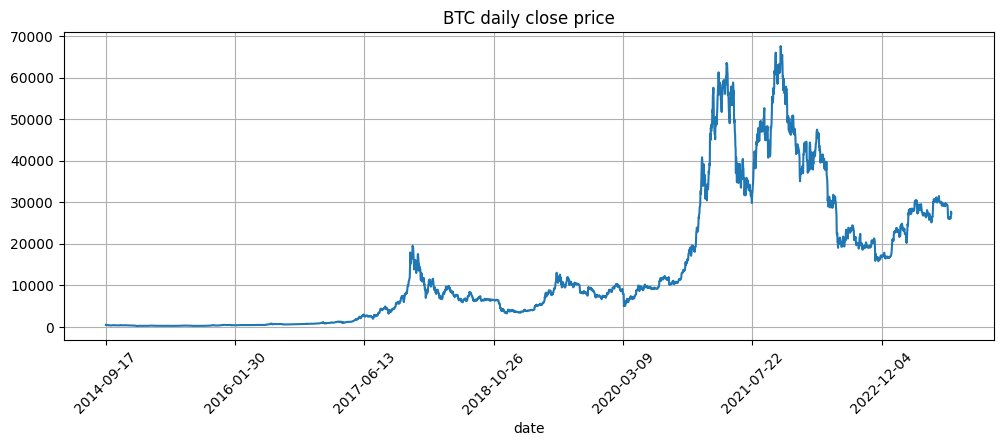

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
BTCprice.set_index("date").close.plot()
plt.grid()
plt.title("BTC daily close price")
plt.xticks(rotation=45)
plt.show()

In [3]:
import numpy as np

# obtain the previuos day prices by shifting the dataframe
BTCprice["log_return"] = np.log(BTCprice["close"]) - np.log(BTCprice["close"].shift(1))
BTCprice

,date,close,log_return
0,2014-09-17,457.334015,NaN
1,2014-09-18,424.440002,-0.074643
2,2014-09-19,394.795990,-0.072402
3,2014-09-20,408.903992,0.035111
4,2014-09-21,398.821014,-0.024968
...,...,...,...
3265,2023-08-26,26008.462891,-0.001506
3266,2023-08-27,26089.693359,0.003118
3267,2023-08-28,26106.150391,0.000631
3268,2023-08-29,27727.392578,0.060250


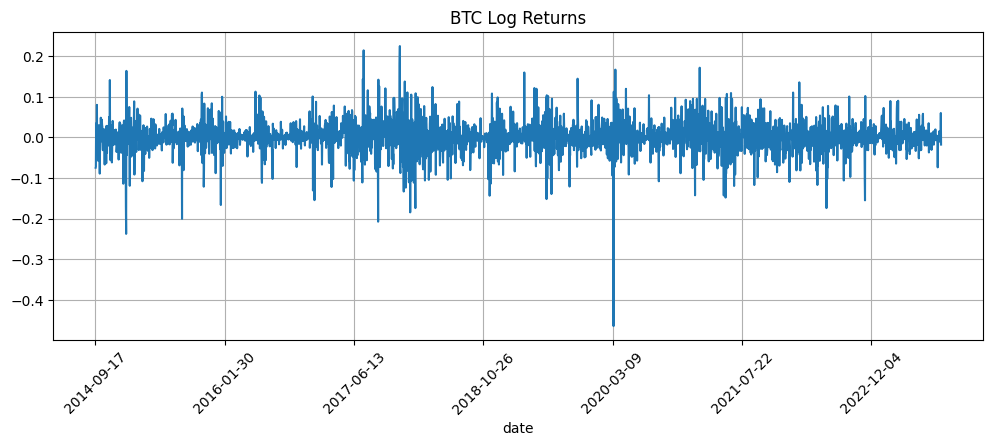

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
BTCprice.set_index("date").log_return.plot()
plt.grid()
plt.title("BTC Log Returns")
plt.xticks(rotation=45)
plt.show()

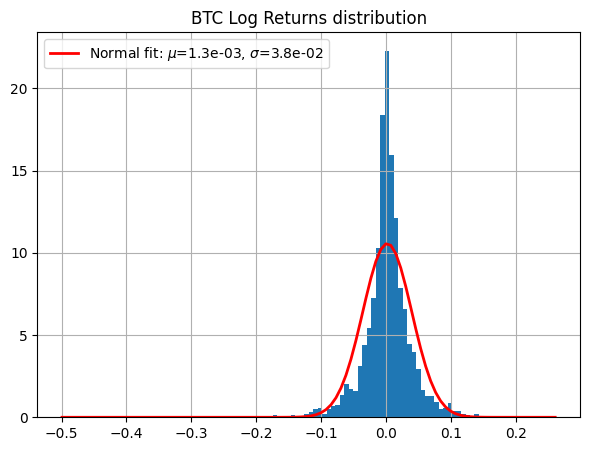

In [6]:
from scipy.stats import norm

# matplotlib histogram
fig, ax = plt.subplots(figsize=(7,5))
ax.grid()
BTCprice.log_return.hist(bins=100, ax = ax, density=True)
ax.set_title("BTC Log Returns distribution")

#scipy fit
mu, std = norm.fit(BTCprice.log_return.dropna())
xmin, xmax = ax.get_xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)

ax.plot(x, p, "red", linewidth=2, label=f"Normal fit: $\\mu$={mu:.1e}, $\\sigma$={std:.1e}")
ax.legend()

plt.show()

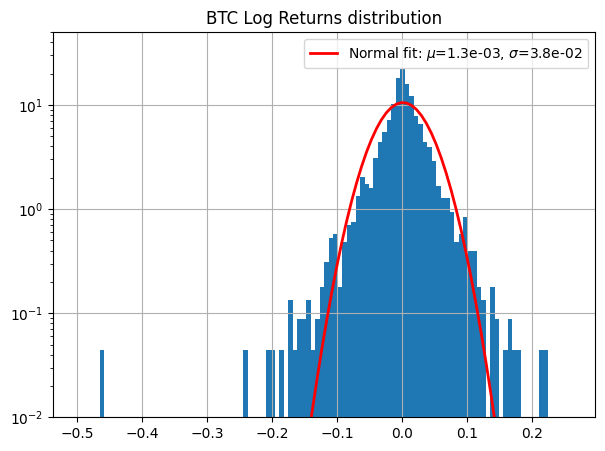

In [7]:
# matplotlib histogram
fig, ax = plt.subplots(figsize=(7,5))
ax.grid()
BTCprice.log_return.hist(bins=100, ax = ax, density=True)
ax.set_title("BTC Log Returns distribution")

#scipy fit
mu, std = norm.fit(BTCprice.log_return.dropna())
xmin, xmax = ax.get_xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)

ax.plot(x, p, "red", linewidth=2, label=f"Normal fit: $\\mu$={mu:.1e}, $\\sigma$={std:.1e}")
ax.legend()
ax.set_yscale("log")
ax.set_ylim(0.01, 50)
plt.show()

# Geometric Browninian motion
$$ d S(t) = \mu S(t) dt + \sigma S(t) dW(t) \quad \implies \quad d \ln S = \ln \left( \frac{S(t + dt)}{S(t)} \right) = \mu^* dt + \sigma dW(t), \quad \mu^* = \mu - \frac{\sigma^2}{2}$$

# Historical volatility
From the log returns it is possible to compute a sample estimator of the historical volatility. The formula is the following:

$$ \sigma_h = \frac{1}{\Delta T} \sqrt{Var\left(\ln\left(\frac{S(t + \Delta T)}{S(t)}\right)\right)}.$$

If we take $\Delta T$ to be $1\, day$, $\sigma_h$ simply becomes the estimated standard deviation of the log returns, and it is measured in $day^{-1}$.

In [8]:
historicalVolatility = BTCprice["log_return"].std()
historicalVolatility

0.037746655311081276

### Rolling volatility

As shown above, the historical volatility is defined as the empirical standard deviation of the log-returns. The hypothesys here is that this kind of volatility remains fixed for the entire existence of the asset. \\
To overcome this, we can compute the standard deviation not on the whole dataset but on a rolling windows of arbitrary size, obtaining a rolling volatility that captures volatility fluctuations.

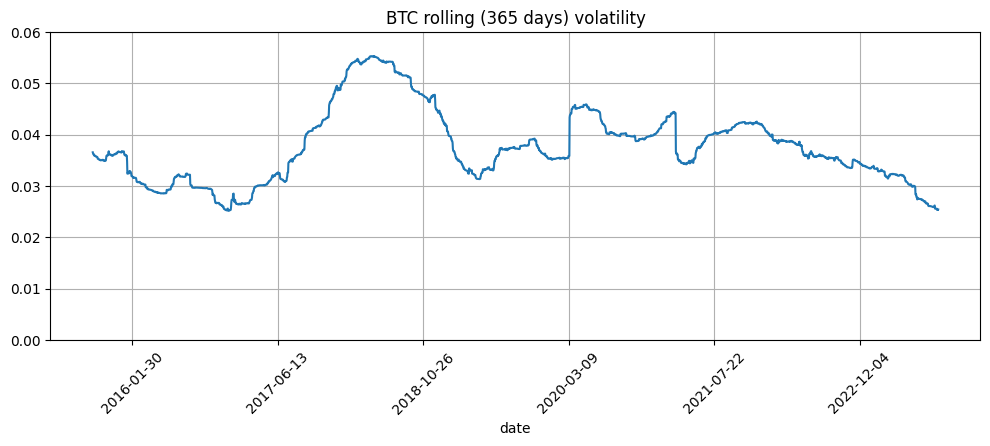

In [20]:
window = 365
rollingVolatility = BTCprice["log_return"].rolling(window).std()
BTCprice[f"rollingVolatility_{window}"] = rollingVolatility

# plot
BTCprice.plot(x="date", y=f"rollingVolatility_{window}", legend=False, figsize=(12,4))
plt.grid()
plt.title(f"BTC rolling ({window} days) volatility")
plt.xticks(rotation=45)
plt.ylim(0, 0.06)
plt.show()

# Black&Scholes Option pricing

# Buy&Hold strategy